This example script aims to monitor the top world exported commodities

In [ ]:
# Install a pip comtradeapicall package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install --upgrade comtradeapicall
# Install a pip pandas package in the current Jupyter kernel
!{sys.executable} -m pip install pandas
# Install a pip matplotlib package in the current Jupyter kernel
!{sys.executable} -m pip install matplotlib

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import comtradeapicall

In [57]:
# use .env to store the subscription key
from dotenv import load_dotenv
import os

load_dotenv()
subscription_key = os.getenv("SUBSCRIPTION_KEY")

Input parameters: random reporter code in ISO, base year = current year - 3 (to obtain the top products), flow and no of months

In [58]:
# get the latest year
from datetime import datetime
flow = 'X'

current_year = datetime.now().year
last_years = [str(year) for year in range(current_year, current_year - 12, -1)]
formatted_years = ",".join(last_years)

countryISO = 'W00'

Get Trade Matrix data

In [64]:
# get the top 2 digits top world exported commodities
# classic breakdown mode will set the partner2Code to World, customsCode to Total, and motCode to Total.
df_CA_BaseYear_2Digit = comtradeapicall.getTradeMatrix(subscription_key, typeCode='C', freqCode='A', period=formatted_years, reporterCode=comtradeapicall.convertCountryIso3ToCode(
    countryISO), cmdCode='AG2', flowCode=flow, partnerCode=0, includeDesc=True)

Plot time series top trade products 

In [66]:
from matplotlib.ticker import FuncFormatter
df = df_CA_BaseYear_2Digit

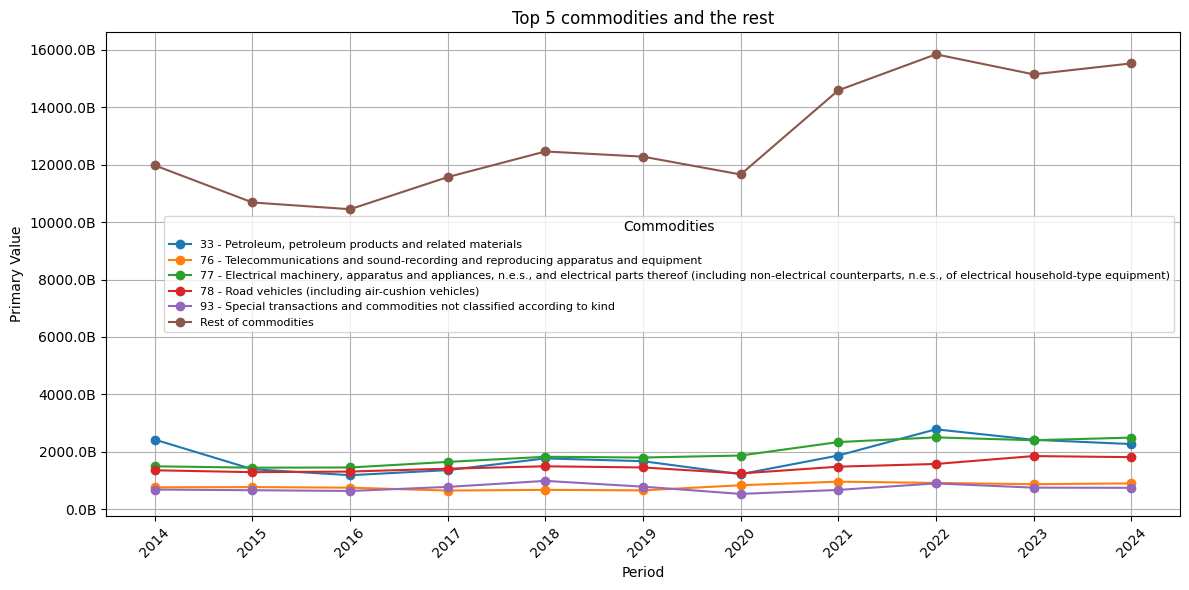

Top 5 commodities with descriptions:
   cmdCode                                            cmdDesc
22      33  Petroleum, petroleum products and related mate...
51      76  Telecommunications and sound-recording and rep...
52      77  Electrical machinery, apparatus and appliances...
53      78     Road vehicles (including air-cushion vehicles)
63      93  Special transactions and commodities not class...


In [67]:
# Ensure relevant columns exist
required_columns = ['cmdCode', 'cmdDesc', 'primaryValue', 'period']
if not all(col in df.columns for col in required_columns):
    raise ValueError("Required columns are missing from the dataset.")

# Group by cmdCode and sum primaryValue to find top cmdCodes
top_cmd_codes = df.groupby(
    'cmdCode')['primaryValue'].sum().nlargest(5).index.tolist()

# Separate top and rest
filtered_top = df[df['cmdCode'].isin(top_cmd_codes)].copy()
filtered_rest = df[~df['cmdCode'].isin(top_cmd_codes)].copy()

# Create combined label for top
filtered_top['cmdLabel'] = filtered_top['cmdCode'].astype(
    str) + ' - ' + filtered_top['cmdDesc']

# Aggregate top  by period and cmdLabel
top_agg = filtered_top.groupby(['period', 'cmdLabel'])[
    'primaryValue'].sum().reset_index()

# Aggregate rest by period and assign label
rest_agg = filtered_rest.groupby('period')['primaryValue'].sum().reset_index()
rest_agg['cmdLabel'] = 'Rest of commodities'

# Combine both
total_agg = pd.concat([top_agg, rest_agg], ignore_index=True)

# Pivot for plotting
pivot_df = total_agg.pivot(
    index='period', columns='cmdLabel', values='primaryValue')

# Plot using Matplotlib
plt.figure(figsize=(12, 6))
for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], marker='o', label=column)

plt.title('Top 5 commodities and the rest')
plt.xlabel('Period')
plt.ylabel('Primary Value')

# Format y-axis: billions with 1 decimal
formatter = FuncFormatter(lambda x, _: f'{x/1e9:.1f}B')
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(title='Commodities', fontsize=8)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print confirmation and top cmdCodes with descriptions
top_cmd_desc = df[df['cmdCode'].isin(top_cmd_codes)][[
    'cmdCode', 'cmdDesc']].drop_duplicates()
print("Top 5 commodities with descriptions:")
print(top_cmd_desc)

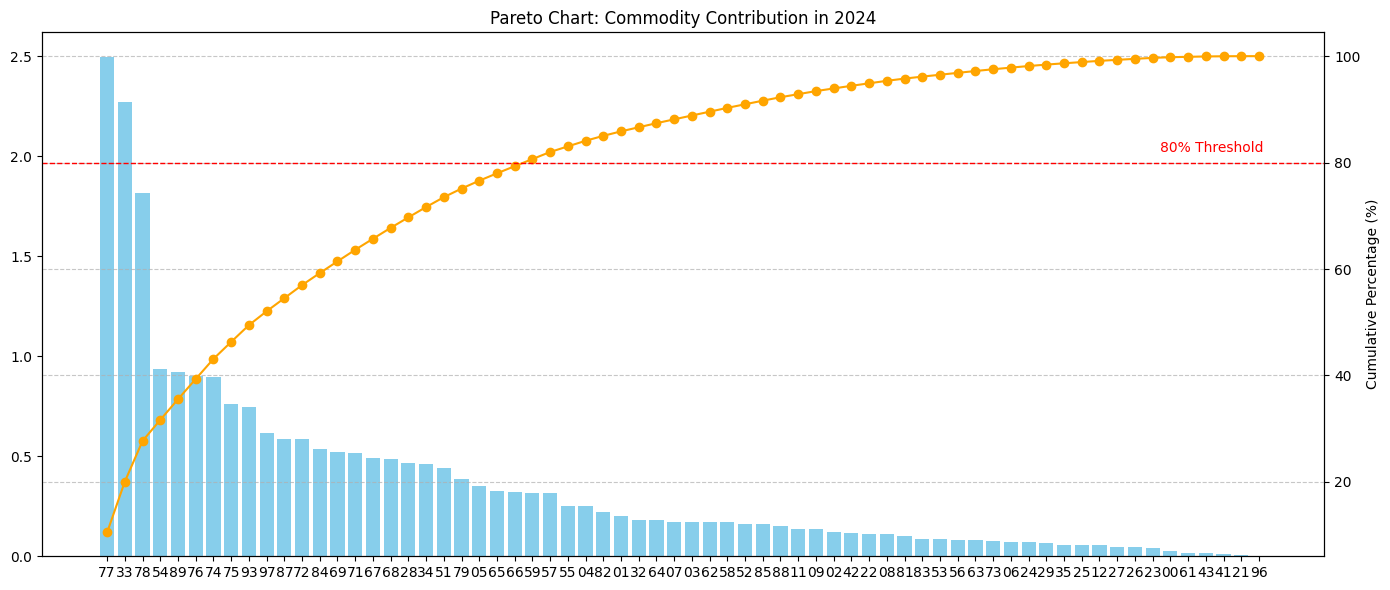

Total commodity: 66
Top 10 commodity by primaryValue:
cmdCode
77    2.495189e+12
33    2.271015e+12
78    1.814975e+12
54    9.384544e+11
89    9.230685e+11
76    9.016260e+11
74    8.969961e+11
75    7.596845e+11
93    7.473998e+11
97    6.183989e+11
Name: primaryValue, dtype: float64


In [68]:
# Filter for year 2024
df_2024 = df[df['refYear'] == 2024]

# Group by cmdCode and sum primaryValue
cmd_totals = df_2024.groupby(
    'cmdCode')['primaryValue'].sum().sort_values(ascending=False)

# Calculate cumulative percentage
cumulative_percentage = cmd_totals.cumsum() / cmd_totals.sum() * 100

# Prepare Pareto chart
plt.figure(figsize=(14, 6))

# Bar chart for individual contributions
cmd_codes = cmd_totals.index.astype(str)
plt.bar(cmd_codes, cmd_totals / 1e12, color='skyblue',
        label='Primary Value (Trillions)')

# Line chart for cumulative percentage
plt.twinx()
plt.plot(cmd_codes, cumulative_percentage,
         color='orange', marker='o', label='Cumulative %')

# Titles and labels
plt.title('Pareto Chart: Commodity Contribution in 2024')
plt.ylabel('Cumulative Percentage (%)')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show horizontal line at 80%
plt.axhline(80, color='red', linestyle='--', linewidth=1)
plt.text(len(cmd_codes) * 0.9, 82, '80% Threshold', color='red')

plt.tight_layout()
plt.show()

# Print summary
print(f"Total commodity: {len(cmd_totals)}")
print("Top 10 commodity by primaryValue:")
print(cmd_totals.head(10))